In [ ]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.datasets import cifar10

# Importa a função imshow específica para o Colab
from google.colab.patches import cv2_imshow

In [ ]:
#Parâmetros
TRUCK_CLASS_ID = 9 # Classe dos caminhões no CIFAR-10
IMAGE_SIZE = 32 # Imagens do CIFAR-10 são 32x32


In [ ]:
# HOG parameters (ajuste se necessário)
HOG_WIN_SIZE = (IMAGE_SIZE, IMAGE_SIZE) # Tamanho da janela para HOG (tamanho da imagem do CIFAR)
HOG_BLOCK_SIZE = (16, 16)
HOG_BLOCK_STRIDE = (8, 8)
HOG_CELL_SIZE = (8, 8)
HOG_NBINS = 9

In [ ]:
# Sliding Window parameters (para a detecção)
SLIDING_WINDOW_STEP = 4 # Passos da janela deslizante

In [ ]:
# NMS parameters
NMS_IOU_THRESHOLD = 0.3 # Limiar de IOU para NMS

In [ ]:
# --- 1. Carregamento e Pré-processamento dos Dados ---
def load_cifar10_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Normaliza pixels para 0-255 (se não estiverem)
    x_train = x_train.astype('uint8') # HOG espera uint8
    x_test = x_test.astype('uint8')   # HOG espera uint8

    # Separa caminhões (positivos) e não-caminhões (negativos) para treino do classificador
    truck_train_images = x_train[y_train.flatten() == TRUCK_CLASS_ID]
    non_truck_train_images = x_train[y_train.flatten() != TRUCK_CLASS_ID]

    # Para teste de detecção, usaremos as imagens de teste completas
    # do CIFAR-10, especialmente as de caminhões.

    return truck_train_images, non_truck_train_images, x_test, y_test

In [ ]:
# --- 2. Extração de Descritores (HOG) ---
def extract_hog_features(image):
    # Verifica se a imagem é válida e tem 3 canais (RGB)
    if image is None or image.size == 0:
        return np.array([])

    # Redimensiona para o tamanho esperado pelo HOG_WIN_SIZE, se necessário
    if image.shape[0] != HOG_WIN_SIZE[1] or image.shape[1] != HOG_WIN_SIZE[0]:
        try:
            image = cv2.resize(image, HOG_WIN_SIZE, interpolation=cv2.INTER_LINEAR)
        except cv2.error:
            print(f"Erro ao redimensionar imagem para {HOG_WIN_SIZE}. Pulando.")
            return np.array([])

    # Converte para tons de cinza
    if len(image.shape) == 3: # Se for RGB/BGR
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif len(image.shape) == 2: # Se já for grayscale
        gray_image = image
    else:
        print("Formato de imagem inválido. Espera-se 2 ou 3 canais.")
        return np.array([])

    # A linha abaixo foi o foco da correção: verifique se está alinhada corretamente
    hog = cv2.HOGDescriptor(HOG_WIN_SIZE, HOG_BLOCK_SIZE, HOG_BLOCK_STRIDE, HOG_CELL_SIZE, HOG_NBINS)

    features = hog.compute(gray_image)
    return features.flatten() if features is not None else np.array([])


In [ ]:
# --- 3. Treinamento do Classificador (SVM) ---
def train_svm_classifier(truck_images, non_truck_images):
    print("Extraindo features HOG para imagens de caminhões...")
    features_positive = [extract_hog_features(img) for img in truck_images
                         if img.shape[0] == IMAGE_SIZE and img.shape[1] == IMAGE_SIZE and img.shape[2] == 3]

    print("Extraindo features HOG para imagens não-caminhões...")
    features_negative = [extract_hog_features(img) for img in non_truck_images[:len(truck_images)]
                         if img.shape[0] == IMAGE_SIZE and img.shape[1] == IMAGE_SIZE and img.shape[2] == 3]

    features_positive = [f for f in features_positive if f.size > 0]
    features_negative = [f for f in features_negative if f.size > 0]

    all_features_list = features_positive + features_negative
    all_labels = np.array([1] * len(features_positive) + [0] * len(features_negative))

    if not all_features_list:
        print("Erro: Nenhuma feature HOG válida extraída para treinamento. Não é possível treinar o SVM.")
        return None

    min_feature_len = min(len(f) for f in all_features_list)
    all_features = np.array([f[:min_feature_len] for f in all_features_list])

    print(f"Número total de amostras para treinamento: {len(all_labels)}")
    print(f"Tamanho da feature HOG: {min_feature_len}")

    X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)

    print("Treinando classificador SVM...")
    svm = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    print(f"Acurácia do SVM: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precisão do SVM: {precision_score(y_test, y_pred):.2f}")
    print(f"Revocação do SVM: {recall_score(y_test, y_pred):.2f}")
    print(f"F1-Score do SVM: {f1_score(y_test, y_pred):.2f}")

    return svm

In [ ]:
# --- NMS Function (Implementação Simples) ---
def non_max_suppression(boxes, scores, overlapThresh):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] + boxes[:, 0]
    y2 = boxes[:, 3] + boxes[:, 1]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    return pick

In [ ]:
# --- 4. Detecção de Objetos com Janela Deslizante ---
def detect_objects_sliding_window(image, svm_classifier):
    detections = []

    # Redimensiona a imagem de teste para permitir a "janela deslizante"
    resized_test_image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)

    window_scales = [1.0]

    for scale_factor in window_scales:
        current_win_w = int(HOG_WIN_SIZE[0] * scale_factor)
        current_win_h = int(HOG_WIN_SIZE[1] * scale_factor)

        if current_win_w > resized_test_image.shape[1] or current_win_h > resized_test_image.shape[0]:
            continue

        for y in range(0, resized_test_image.shape[0] - current_win_h + 1, SLIDING_WINDOW_STEP):
            for x in range(0, resized_test_image.shape[1] - current_win_w + 1, SLIDING_WINDOW_STEP):
                window = resized_test_image[y:y + current_win_h, x:x + current_win_w]

                window_for_hog = cv2.resize(window, HOG_WIN_SIZE, interpolation=cv2.INTER_LINEAR)

                features = extract_hog_features(window_for_hog)

                if features.size > 0:
                    prediction = svm_classifier.predict(features.reshape(1, -1))[0]

                    if prediction == 1:
                        score = svm_classifier.predict_proba(features.reshape(1, -1))[0][1]

                        original_x = int(x * (IMAGE_SIZE / 64.0))
                        original_y = int(y * (IMAGE_SIZE / 64.0))
                        original_w = int(current_win_w * (IMAGE_SIZE / 64.0))
                        original_h = int(current_win_h * (IMAGE_SIZE / 64.0))

                        detections.append([original_x, original_y, original_w, original_h, score])

    if detections:
        boxes = np.array([d[:4] for d in detections])
        scores = np.array([d[4] for d in detections])

        min_score_threshold = 0.6

        filtered_indices = np.where(scores >= min_score_threshold)[0]
        boxes = boxes[filtered_indices]
        scores = scores[filtered_indices]

        if len(boxes) > 0:
            picked_indices = non_max_suppression(boxes, scores, NMS_IOU_THRESHOLD)
            filtered_detections = [detections[filtered_indices[i]] for i in picked_indices]
        else:
            filtered_detections = []
    else:
        filtered_detections = []

    return filtered_detections

In [ ]:
# --- 5. Cálculo das Métricas de Avaliação ---
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    iou = interArea / float(boxAArea + boxBArea - interArea) if (boxAArea + boxBArea - interArea) > 0 else 0
    return iou

def evaluate_detection_metrics(predicted_boxes_list, ground_truth_boxes_list, iou_threshold=0.5):
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    for img_idx in range(len(ground_truth_boxes_list)):
        gt_boxes = ground_truth_boxes_list[img_idx]
        pred_boxes = predicted_boxes_list[img_idx]

        matched_gt = [False] * len(gt_boxes)
        matched_pred = [False] * len(pred_boxes)

        for i, gt_box in enumerate(gt_boxes):
            best_iou = 0
            best_pred_idx = -1
            for j, pred_box_data in enumerate(pred_boxes):
                if matched_pred[j]:
                    continue
                pred_box = pred_box_data[:4]
                iou = calculate_iou(gt_box, pred_box)
                if iou > best_iou:
                    best_iou = iou
                    best_pred_idx = j

            if best_iou >= iou_threshold:
                total_true_positives += 1
                matched_gt[i] = True
                matched_pred[best_pred_idx] = True
            else:
                total_false_negatives += 1

        total_false_positives += sum(1 for matched in matched_pred if not matched)

    precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

In [ ]:
# --- Loop Principal ---
if __name__ == "__main__":
    truck_train_images, non_truck_train_images, x_test, y_test = load_cifar10_data()

    # 1. Treinar o classificador SVM
    svm_model = train_svm_classifier(truck_train_images, non_truck_train_images)

    if svm_model is None:
        print("Não foi possível treinar o modelo SVM. A sair.")
    else:
        print("\nIniciando a fase de deteção de objetos nas imagens de teste...")

        num_display_images = 10
        truck_test_indices = np.where(y_test.flatten() == TRUCK_CLASS_ID)[0]
        non_truck_test_indices = np.where(y_test.flatten() != TRUCK_CLASS_ID)[0]

        display_indices_trucks = np.random.choice(truck_test_indices, min(num_display_images // 2, len(truck_test_indices)), replace=False)
        display_indices_non_trucks = np.random.choice(non_truck_test_indices, min(num_display_images // 2, len(non_truck_test_indices)), replace=False)

        images_to_display = []
        labels_to_display = []
        original_indices = []

        for idx in display_indices_trucks:
            images_to_display.append(x_test[idx])
            labels_to_display.append("Caminhão (Real)")
            original_indices.append(idx)

        for idx in display_indices_non_trucks:
            images_to_display.append(x_test[idx])
            labels_to_display.append("Não Caminhão (Real)")
            original_indices.append(idx)

        all_predicted_boxes = []
        all_ground_truth_boxes = []

        for i, img in enumerate(images_to_display):
            print(f"A processar imagem {original_indices[i]+1}/{len(x_test)} ({labels_to_display[i]})...")

            detected_boxes = detect_objects_sliding_window(img, svm_model)
            all_predicted_boxes.append(detected_boxes)

            if labels_to_display[i] == "Camião (Real)":
                all_ground_truth_boxes.append([[0, 0, IMAGE_SIZE, IMAGE_SIZE]])
            else:
                all_ground_truth_boxes.append([])

            display_img = cv2.resize(img, (IMAGE_SIZE * 4, IMAGE_SIZE * 4), interpolation=cv2.INTER_NEAREST)

            for (x, y, w, h, score) in detected_boxes:
                display_x = int(x * 4)
                display_y = int(y * 4)
                display_w = int(w * 4)
                display_h = int(h * 4)
                cv2.rectangle(display_img, (display_x, display_y), (display_x + display_w, display_y + display_h), (0, 255, 0), 2)
                cv2.putText(display_img, f"{score:.2f}", (display_x, display_y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

            if labels_to_display[i] == "Caminhão (Real)":
                cv2.rectangle(display_img, (0, 0), (IMAGE_SIZE * 4 -1, IMAGE_SIZE * 4 - 1), (255, 0, 0), 2)
                cv2.putText(display_img, "GT", (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

            cv2_imshow(display_img) # Usando cv2_imshow para Colab

        print("\nCalculando métricas de deteção (baseado em simulação de Ground Truth)...")
        precision_det, recall_det, f1_det = evaluate_detection_metrics(all_predicted_boxes, all_ground_truth_boxes)
        print(f"Precisão da Deteção (Simulada): {precision_det:.2f}")
        print(f"Revocação da Deteção (Simulada): {recall_det:.2f}")
        print(f"F1-Score da Deteção (Simulada): {f1_det:.2f}")


## Parte 2

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Carregar a base de dados
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Selecionar apenas a classe "caminhão" (label = 9)
target_class = 9
mask_train = y_train.flatten() == target_class
mask_test = y_test.flatten() == target_class

x_train = x_train[mask_train]
y_train = y_train[mask_train]

x_test = x_test[mask_test]
y_test = y_test[mask_test]

# Criar um problema binário: caminhão (1) ou não caminhão (0)

x_all = np.concatenate([x_train, x_test])
y_all = np.concatenate([y_train, y_test])

# Definindo y como binário (caminhão = 1)
y_all = np.where(y_all == target_class, 1, 0)

# Normalização
x_all = x_all.astype('float32') / 255.0

# Separar em treino/validação/teste
x_train, x_temp, y_train, y_temp = train_test_split(x_all, y_all, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Aumentador de dados com rotação
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,          # Rotação aleatória entre -30 e 30 graus
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Validação e Teste não têm aumento de dados
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

# Criar os generators
batch_size = 32

train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=batch_size,
    shuffle=True
)

val_generator = test_datagen.flow(
    x_val, y_val,
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow(
    x_test, y_test,
    batch_size=batch_size,
    shuffle=False
)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


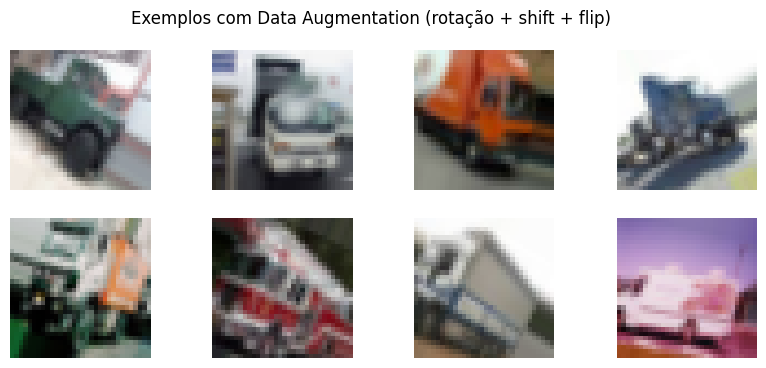

In [3]:
# Mostrar algumas imagens aumentadas
images, labels = next(train_generator)

plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.suptitle('Exemplos com Data Augmentation (rotação + shift + flip)')
plt.show()


In [4]:
from tensorflow.keras import models, layers

def criar_cnn_simples(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # para binário
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [5]:
def criar_cnn_moderada(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # para binário
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [6]:
def criar_cnn_profunda(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # para binário
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [7]:
input_shape = (32, 32, 3)  # CIFAR-10 tem essa dimensão por padrão

model1 = criar_cnn_simples(input_shape)
model2 = criar_cnn_moderada(input_shape)
model3 = criar_cnn_profunda(input_shape)

# Exemplo:
model1.summary()
model2.summary()
model3.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753466567.558803      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753466567.559630      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,977 (652.25 KB)

 Trainable params: 166,977 (652.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,545 (1.36 MB)

 Trainable params: 356,097 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 811,809 (3.10 MB)

 Trainable params: 811,809 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Parâmetros
TRUCK_CLASS_ID = 9
IMAGE_SIZE = 32
BATCH_SIZE = 32
EPOCHS = 10

# --- Preparar os dados ---
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# Binário: Caminhão (1) vs. Não caminhão (0)
x = np.concatenate([x_train_full, x_test])
y = np.concatenate([y_train_full, y_test])
y_bin = np.where(y == TRUCK_CLASS_ID, 1, 0).flatten()

# Normalização
x = x.astype('float32') / 255.0

# Separação em treino, validação e teste
x_train, x_temp, y_train, y_temp = train_test_split(x, y_bin, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = test_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

# --- Treinamento das 3 redes ---
modelos = {
    "CNN Simples": criar_cnn_simples((IMAGE_SIZE, IMAGE_SIZE, 3)),
    "CNN Moderada": criar_cnn_moderada((IMAGE_SIZE, IMAGE_SIZE, 3)),
    "CNN Profunda": criar_cnn_profunda((IMAGE_SIZE, IMAGE_SIZE, 3))
}

historicos = {}

for nome, modelo in modelos.items():
    print(f"\nTreinando {nome}...")
    historico = modelo.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        verbose=1
    )
    historicos[nome] = historico
    modelo.save(f"{nome.replace(' ', '_').lower()}.h5")


Treinando CNN Simples...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1753466574.417604     104 service.cc:148] XLA service 0x7e5268003d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753466574.419339     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753466574.419362     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753466574.767003     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


  11/1313 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.7035 - loss: 0.4879

I0000 00:00:1753466577.307364     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.8966 - loss: 0.2834 - val_accuracy: 0.8969 - val_loss: 0.2182
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8995 - loss: 0.2306 - val_accuracy: 0.9263 - val_loss: 0.2278
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.9163 - loss: 0.2105 - val_accuracy: 0.9339 - val_loss: 0.1756
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.9233 - loss: 0.1923 - val_accuracy: 0.9312 - val_loss: 0.1750
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9291 - loss: 0.1809 - val_accuracy: 0.9477 - val_loss: 0.1477
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9356 - loss: 0.1687 - val_accuracy: 0.9486 - val_loss: 0.1434
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9393 - loss: 0.1622 - val_accuracy: 0.9451 - val_loss: 0.1410
Epoch 8/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9361 - loss: 0.16

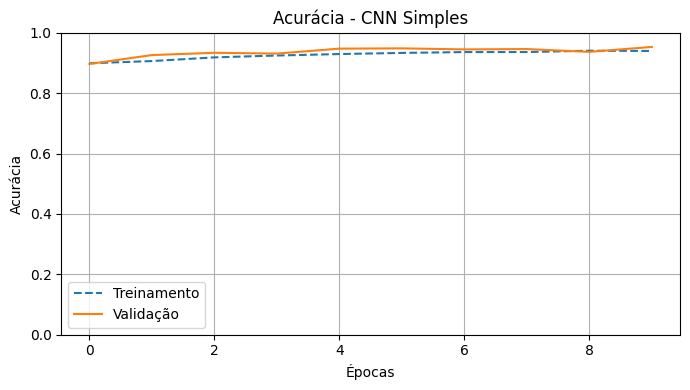

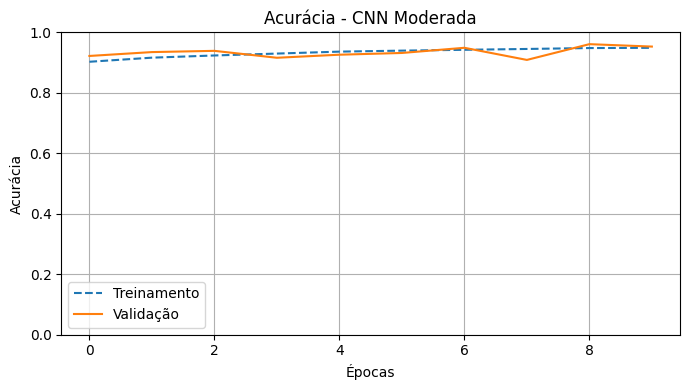

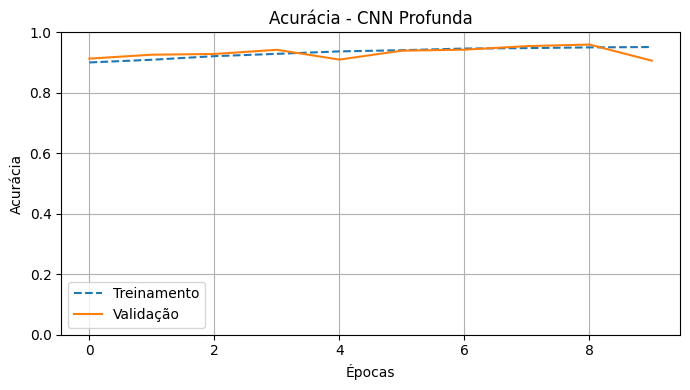

In [9]:
def plotar_resultados(historicos):
    for nome, hist in historicos.items():
        plt.figure(figsize=(7, 4))
        plt.plot(hist.history['accuracy'], label='Treinamento', linestyle='--')
        plt.plot(hist.history['val_accuracy'], label='Validação')
        plt.title(f'Acurácia - {nome}')
        plt.xlabel('Épocas')
        plt.ylabel('Acurácia')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Chamada:
plotar_resultados(historicos)


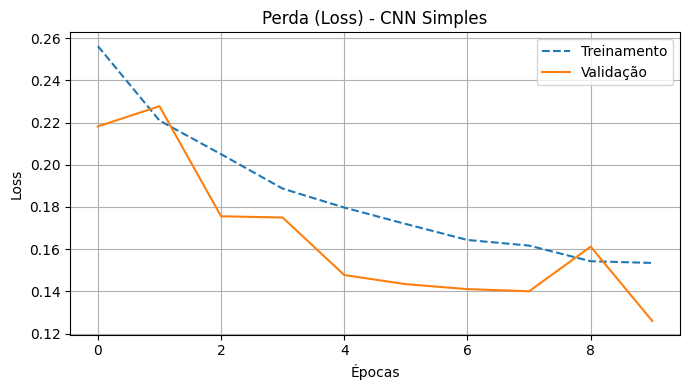

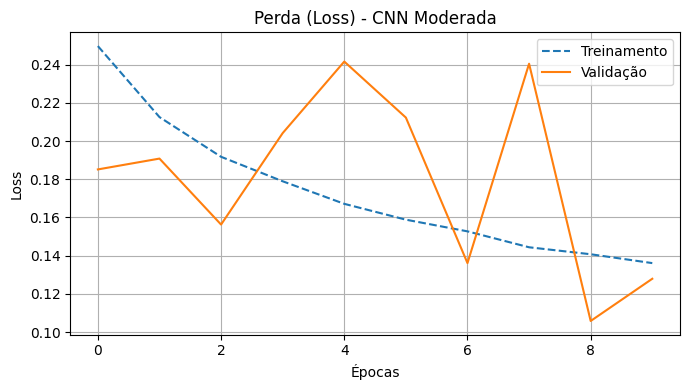

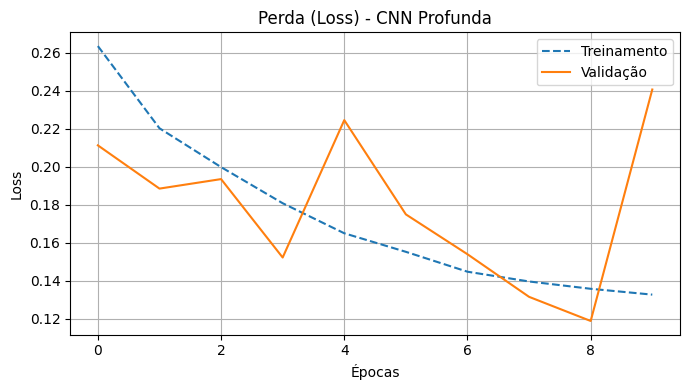

In [10]:
def plotar_loss(historicos):
    for nome, hist in historicos.items():
        plt.figure(figsize=(7, 4))
        plt.plot(hist.history['loss'], label='Treinamento', linestyle='--')
        plt.plot(hist.history['val_loss'], label='Validação')
        plt.title(f'Perda (Loss) - {nome}')
        plt.xlabel('Épocas')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Chamada:
plotar_loss(historicos)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


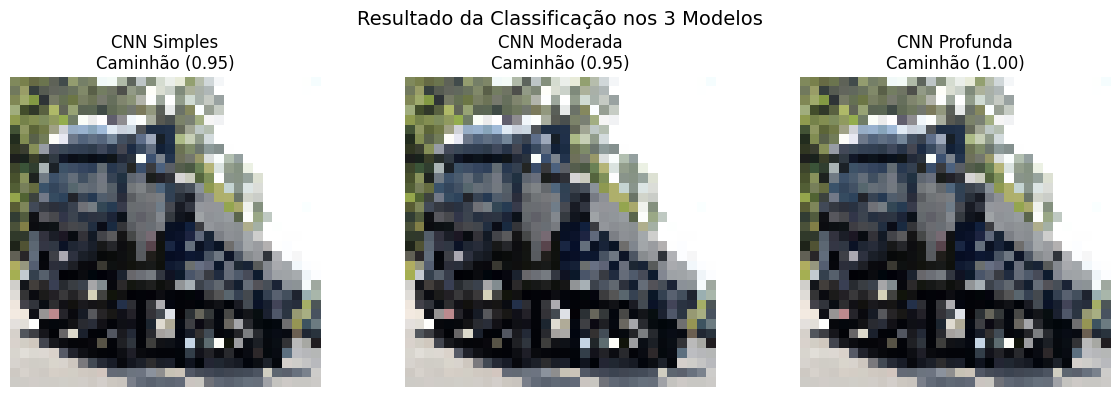

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from tensorflow.keras.models import load_model

# Parâmetros
IMAGE_SIZE = 32
URL = 'https://fotos-estradao-estadao.nyc3.cdn.digitaloceanspaces.com/wp-content/uploads/2022/05/10120845/Actros-2653-13-1160x775.jpg'

# Modelos a testar
modelos = {
    'CNN Simples': 'cnn_simples.h5',
    'CNN Moderada': 'cnn_moderada.h5',
    'CNN Profunda': 'cnn_profunda.h5'
}

# Função para baixar imagem
def baixar_imagem(url):
    response = requests.get(url)
    imagem = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    return imagem_rgb

# Função para testar modelo
def testar_modelo(model_path, imagem):
    modelo = load_model(model_path)
    img_resized = cv2.resize(imagem, (IMAGE_SIZE, IMAGE_SIZE))
    img_norm = img_resized.astype('float32') / 255.0
    img_input = np.expand_dims(img_norm, axis=0)
    pred = modelo.predict(img_input)[0][0]
    classe = 'Caminhão' if pred >= 0.5 else 'Não Caminhão'
    return classe, pred, img_resized

# Baixar imagem da internet
img_teste = baixar_imagem(URL)

# Testar em todos os modelos
plt.figure(figsize=(12, 4))
for i, (nome_modelo, path) in enumerate(modelos.items(), 1):
    classe, confianca, img = testar_modelo(path, img_teste)
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.title(f'{nome_modelo}\n{classe} ({confianca:.2f})')
    plt.axis('off')

plt.suptitle('Resultado da Classificação nos 3 Modelos', fontsize=14)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


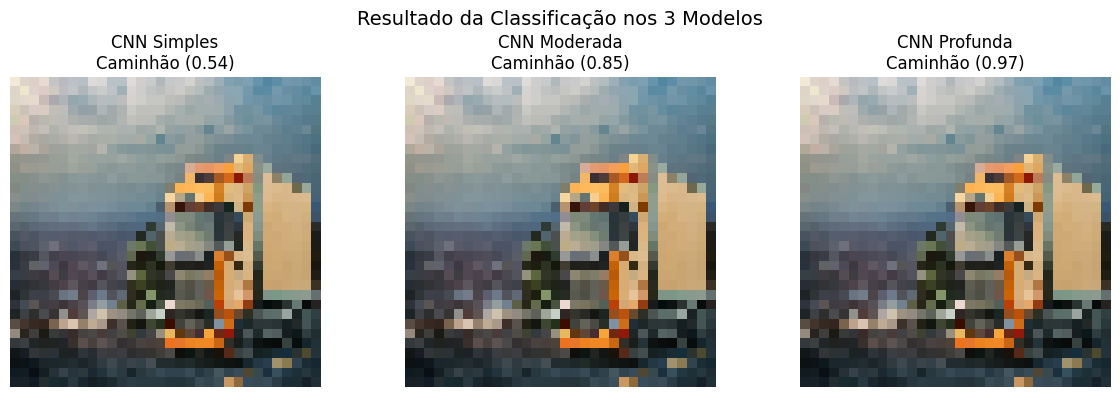

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from tensorflow.keras.models import load_model

# Parâmetros
IMAGE_SIZE = 32
URL = 'https://cpfabbri.com.br/wp-content/uploads/2022/05/Tipos-de-caminhao.jpg'

# Modelos a testar
modelos = {
    'CNN Simples': 'cnn_simples.h5',
    'CNN Moderada': 'cnn_moderada.h5',
    'CNN Profunda': 'cnn_profunda.h5'
}

# Função para baixar imagem
def baixar_imagem(url):
    response = requests.get(url)
    imagem = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    return imagem_rgb

# Função para testar modelo
def testar_modelo(model_path, imagem):
    modelo = load_model(model_path)
    img_resized = cv2.resize(imagem, (IMAGE_SIZE, IMAGE_SIZE))
    img_norm = img_resized.astype('float32') / 255.0
    img_input = np.expand_dims(img_norm, axis=0)
    pred = modelo.predict(img_input)[0][0]
    classe = 'Caminhão' if pred >= 0.5 else 'Não Caminhão'
    return classe, pred, img_resized

# Baixar imagem da internet
img_teste = baixar_imagem(URL)

# Testar em todos os modelos
plt.figure(figsize=(12, 4))
for i, (nome_modelo, path) in enumerate(modelos.items(), 1):
    classe, confianca, img = testar_modelo(path, img_teste)
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.title(f'{nome_modelo}\n{classe} ({confianca:.2f})')
    plt.axis('off')

plt.suptitle('Resultado da Classificação nos 3 Modelos', fontsize=14)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


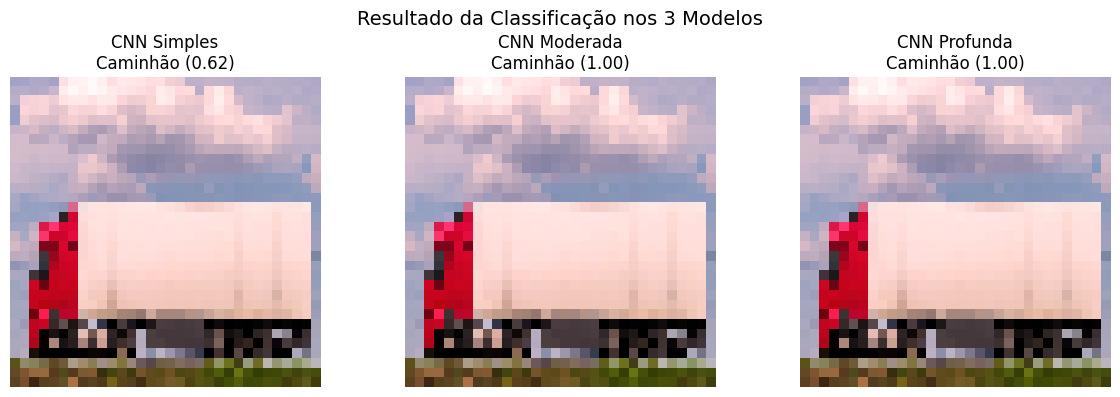

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from tensorflow.keras.models import load_model

# Parâmetros
IMAGE_SIZE = 32
URL = 'https://blog.fretebras.com.br/wp-content/uploads/2022/08/Fretebras_Veiculos_pesados_img-blog.png'

# Modelos a testar
modelos = {
    'CNN Simples': 'cnn_simples.h5',
    'CNN Moderada': 'cnn_moderada.h5',
    'CNN Profunda': 'cnn_profunda.h5'
}

# Função para baixar imagem
def baixar_imagem(url):
    response = requests.get(url)
    imagem = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    return imagem_rgb

# Função para testar modelo
def testar_modelo(model_path, imagem):
    modelo = load_model(model_path)
    img_resized = cv2.resize(imagem, (IMAGE_SIZE, IMAGE_SIZE))
    img_norm = img_resized.astype('float32') / 255.0
    img_input = np.expand_dims(img_norm, axis=0)
    pred = modelo.predict(img_input)[0][0]
    classe = 'Caminhão' if pred >= 0.5 else 'Não Caminhão'
    return classe, pred, img_resized

# Baixar imagem da internet
img_teste = baixar_imagem(URL)

# Testar em todos os modelos
plt.figure(figsize=(12, 4))
for i, (nome_modelo, path) in enumerate(modelos.items(), 1):
    classe, confianca, img = testar_modelo(path, img_teste)
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.title(f'{nome_modelo}\n{classe} ({confianca:.2f})')
    plt.axis('off')

plt.suptitle('Resultado da Classificação nos 3 Modelos', fontsize=14)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


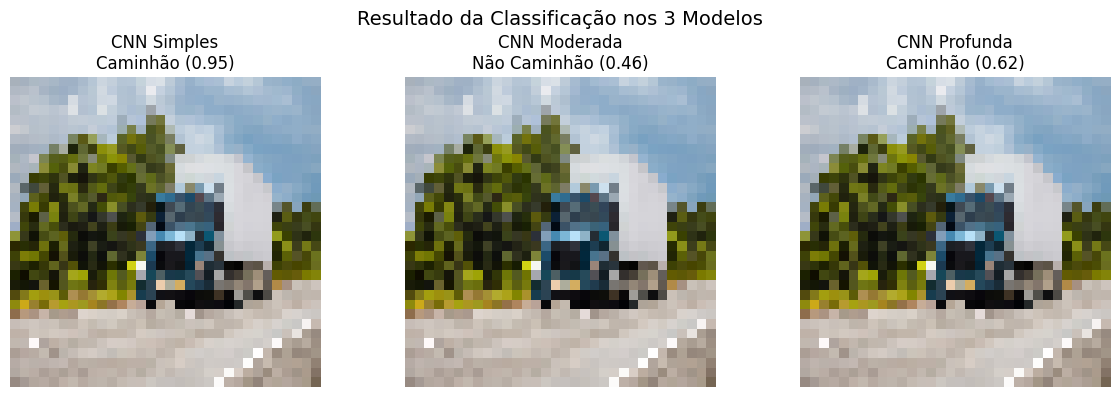

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from tensorflow.keras.models import load_model

# Parâmetros
IMAGE_SIZE = 32
URL = 'https://decklog.com.br/wp-content/uploads/2024/07/Tipos-de-caminhao-dimensoes-e-uso.jpg'

# Modelos a testar
modelos = {
    'CNN Simples': 'cnn_simples.h5',
    'CNN Moderada': 'cnn_moderada.h5',
    'CNN Profunda': 'cnn_profunda.h5'
}

# Função para baixar imagem
def baixar_imagem(url):
    response = requests.get(url)
    imagem = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    return imagem_rgb

# Função para testar modelo
def testar_modelo(model_path, imagem):
    modelo = load_model(model_path)
    img_resized = cv2.resize(imagem, (IMAGE_SIZE, IMAGE_SIZE))
    img_norm = img_resized.astype('float32') / 255.0
    img_input = np.expand_dims(img_norm, axis=0)
    pred = modelo.predict(img_input)[0][0]
    classe = 'Caminhão' if pred >= 0.5 else 'Não Caminhão'
    return classe, pred, img_resized

# Baixar imagem da internet
img_teste = baixar_imagem(URL)

# Testar em todos os modelos
plt.figure(figsize=(12, 4))
for i, (nome_modelo, path) in enumerate(modelos.items(), 1):
    classe, confianca, img = testar_modelo(path, img_teste)
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.title(f'{nome_modelo}\n{classe} ({confianca:.2f})')
    plt.axis('off')

plt.suptitle('Resultado da Classificação nos 3 Modelos', fontsize=14)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


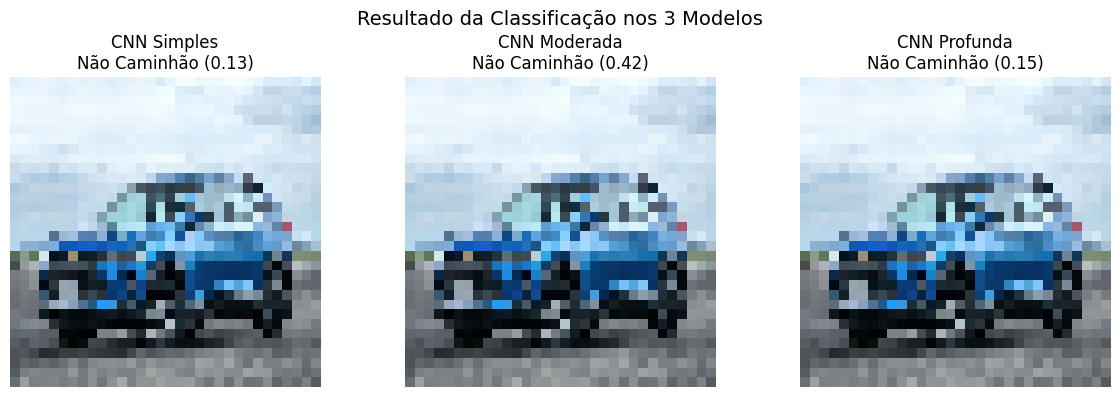

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from tensorflow.keras.models import load_model

# Parâmetros
IMAGE_SIZE = 32
URL = 'https://s2-autoesporte.glbimg.com/mYgwlPa7vtIiUk6kROUxJUi2yyo=/0x0:620x413/984x0/smart/filters:strip_icc()/i.s3.glbimg.com/v1/AUTH_cf9d035bf26b4646b105bd958f32089d/internal_photos/bs/2020/a/4/Ik8J1fQYirf6wYRvRJ8Q/2020-03-20-novo-tracker-1.jpg'

# Modelos a testar
modelos = {
    'CNN Simples': 'cnn_simples.h5',
    'CNN Moderada': 'cnn_moderada.h5',
    'CNN Profunda': 'cnn_profunda.h5'
}

# Função para baixar imagem
def baixar_imagem(url):
    response = requests.get(url)
    imagem = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    return imagem_rgb

# Função para testar modelo
def testar_modelo(model_path, imagem):
    modelo = load_model(model_path)
    img_resized = cv2.resize(imagem, (IMAGE_SIZE, IMAGE_SIZE))
    img_norm = img_resized.astype('float32') / 255.0
    img_input = np.expand_dims(img_norm, axis=0)
    pred = modelo.predict(img_input)[0][0]
    classe = 'Caminhão' if pred >= 0.5 else 'Não Caminhão'
    return classe, pred, img_resized

# Baixar imagem da internet
img_teste = baixar_imagem(URL)

# Testar em todos os modelos
plt.figure(figsize=(12, 4))
for i, (nome_modelo, path) in enumerate(modelos.items(), 1):
    classe, confianca, img = testar_modelo(path, img_teste)
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.title(f'{nome_modelo}\n{classe} ({confianca:.2f})')
    plt.axis('off')

plt.suptitle('Resultado da Classificação nos 3 Modelos', fontsize=14)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


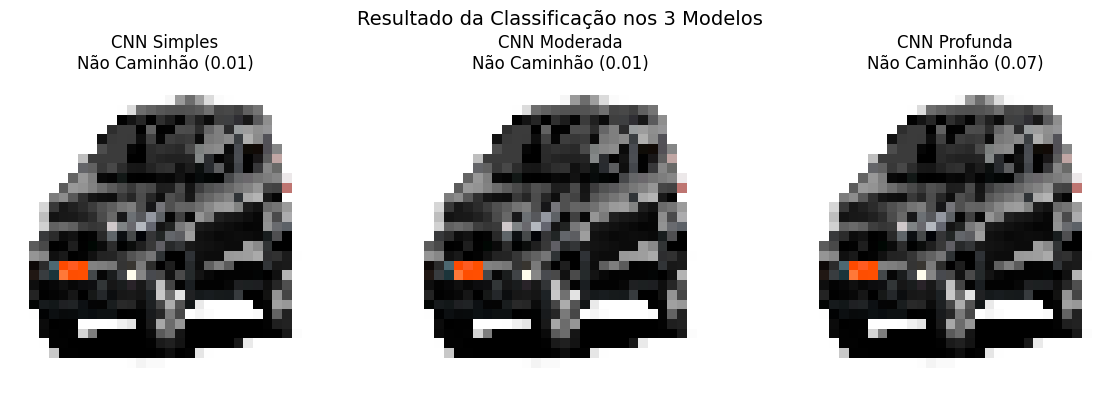

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from tensorflow.keras.models import load_model

# Parâmetros
IMAGE_SIZE = 32
URL = 'https://storage.googleapis.com/movida-public-images/modelos/3210_image.jpg'
# Modelos a testar
modelos = {
    'CNN Simples': 'cnn_simples.h5',
    'CNN Moderada': 'cnn_moderada.h5',
    'CNN Profunda': 'cnn_profunda.h5'
}

# Função para baixar imagem
def baixar_imagem(url):
    response = requests.get(url)
    imagem = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    return imagem_rgb

# Função para testar modelo
def testar_modelo(model_path, imagem):
    modelo = load_model(model_path)
    img_resized = cv2.resize(imagem, (IMAGE_SIZE, IMAGE_SIZE))
    img_norm = img_resized.astype('float32') / 255.0
    img_input = np.expand_dims(img_norm, axis=0)
    pred = modelo.predict(img_input)[0][0]
    classe = 'Caminhão' if pred >= 0.5 else 'Não Caminhão'
    return classe, pred, img_resized

# Baixar imagem da internet
img_teste = baixar_imagem(URL)

# Testar em todos os modelos
plt.figure(figsize=(12, 4))
for i, (nome_modelo, path) in enumerate(modelos.items(), 1):
    classe, confianca, img = testar_modelo(path, img_teste)
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.title(f'{nome_modelo}\n{classe} ({confianca:.2f})')
    plt.axis('off')

plt.suptitle('Resultado da Classificação nos 3 Modelos', fontsize=14)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


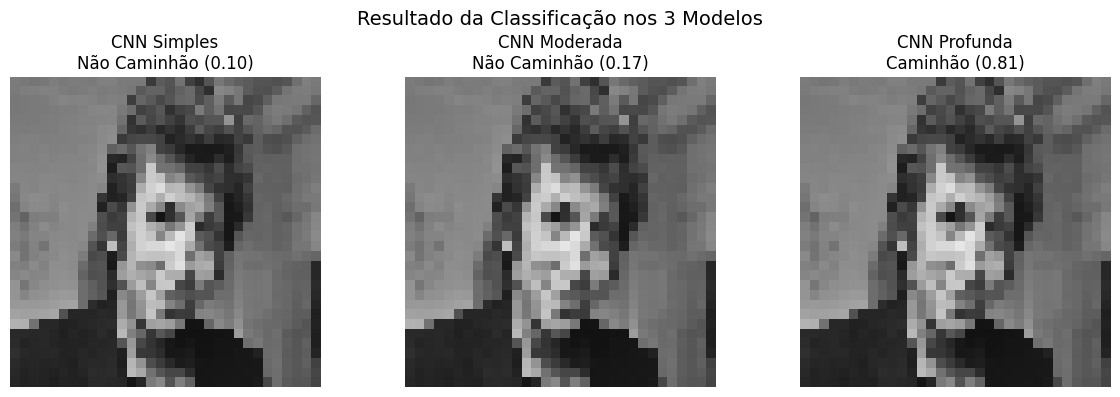

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from tensorflow.keras.models import load_model

# Parâmetros
IMAGE_SIZE = 32
URL = 'https://veja.abril.com.br/wp-content/uploads/2016/12/bob-dylan-19650428-005-620x413.jpg?crop=1&resize=1212,909'
# Modelos a testar
modelos = {
    'CNN Simples': 'cnn_simples.h5',
    'CNN Moderada': 'cnn_moderada.h5',
    'CNN Profunda': 'cnn_profunda.h5'
}

# Função para baixar imagem
def baixar_imagem(url):
    response = requests.get(url)
    imagem = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    return imagem_rgb

# Função para testar modelo
def testar_modelo(model_path, imagem):
    modelo = load_model(model_path)
    img_resized = cv2.resize(imagem, (IMAGE_SIZE, IMAGE_SIZE))
    img_norm = img_resized.astype('float32') / 255.0
    img_input = np.expand_dims(img_norm, axis=0)
    pred = modelo.predict(img_input)[0][0]
    classe = 'Caminhão' if pred >= 0.5 else 'Não Caminhão'
    return classe, pred, img_resized

# Baixar imagem da internet
img_teste = baixar_imagem(URL)

# Testar em todos os modelos
plt.figure(figsize=(12, 4))
for i, (nome_modelo, path) in enumerate(modelos.items(), 1):
    classe, confianca, img = testar_modelo(path, img_teste)
    plt.subplot(1, 3, i)
    plt.imshow(img)
    plt.title(f'{nome_modelo}\n{classe} ({confianca:.2f})')
    plt.axis('off')

plt.suptitle('Resultado da Classificação nos 3 Modelos', fontsize=14)
plt.tight_layout()
plt.show()
